<h1>Capstone EDA and Image Augmentation</h1>

This notebook contains exploratory data analysis, steps taken to clean the dataset, and augment existing images for new image creation. 

In [2]:
import numpy as np
import albumentations as A
import cv2
from PIL import Image, ImageShow
import shutil
import os
import re
from matplotlib import pyplot as plt
import random
import pandas as pd
import seaborn as sns
%matplotlib inline

The following code was used to train/test split images

In [10]:
img_source = "./cleaned_data/train/images"
annot_source = "./cleaned_data/train/labels/"
img_destination = "./cleaned_data/test/images/"
annot_destination = "./cleaned_data/test/labels/"

img_files = os.listdir(img_source)
# i = 1
# for file in img_files:
#     if i % 5 == 0:
#         new_img_path = shutil.move(f"{img_source}/{file}", img_destination)
#     i+=1

annot_files = os.listdir(annot_source)
# j = 1
# for file in annot_files:
#     if j % 5 == 0:
#         new_annot_path = shutil.move(f"{annot_source}/{file}", annot_destination)
#     j+=1

<h2>Data Preview and cleaning</h2>

All images are sized (416, 416, 3)<br>
<br>
Total images: 2527 from the original dataset<br><br>
Training photos:  10,393<br>
•	2,022 images from the original dataset<br>
•	8,371 images augmented from the original<br><br>
Testing photos: <br>
•	505 images from the original databasel<br>
•	None augmented so far<br><br>
Removed because the guns depicted were holstered: 34<br>
Removed becuase the guns depicted were not handguns: 26<br>
Removed for other reasons: 384<br>
<br>
Other reasons include:<br>
•	Image depicts a cartoon weapon<br>
•	Image is from a video game<br>
•	Watermark too prominent<br>
•	Poor image quality<br>
•	Barely visible<br>
•	Technical drawing<br>
•	Wood or toy gun<br>
<br>
Those removed because of not being a handgun were either a long gun or not a gun at all (ie paint spray gun)

In [11]:
#Below function reads annotation files and returns bounding box annotations as a list
def read_file(file):
    list = []
    with open(file, 'rt') as fd:
        read = fd.read()
        stuff = read.split()
        stuff = [float(i) for i in stuff]
        n = 5
        for i in range(0, int((len(stuff)/5))):
            list.append(stuff[n-4:n])
            n += 5
    return list

In [12]:
#for use if I ever decide I need padding on images
def add_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result

#Source: https://note.nkmk.me/en/python-pillow-add-margin-expand-canvas/

Use the below function to turn images into new, augmented images

In [13]:
def augment_images(picture_total, source='./cleaned_data', sett='train'):
    """picture_total: How many pictures you would like there to be in the directory. The number of augmented images will be 
    picture_total - images already in directory. 
    
    source: directory where images and labels directories are located
    
    sett: train or test
    """
    path, dirs, files = next(os.walk(f'{source}/{sett}/images'))
    file_count = len(files)
    while file_count <= picture_total:
        try:
            #set sett to train or test
            img_source = f'{source}/{sett}/images'
            annot_source = f'{source}/{sett}/labels'
            img_files = os.listdir(img_source)
            annot_files = os.listdir(annot_source)

            train_labels_list = []

            keys=[i for i in img_files] 
            values= [read_file(f'{source}/{sett}/labels/{i}') for i in annot_files]
            dictionary = dict(zip(keys, values)) 
            dkeys = [i for i in dictionary.keys()]

            #Here is where the meat of it is:
            for i in range(0,picture_total):
                path, dirs, files = next(os.walk(f'{source}/{sett}/images'))
                file_count = len(files)
                file_name = f'aug_img{file_count+1}'
                image_name = random.choice(dkeys) #starts with a random image from the image pool
                pillow_image = Image.open(f"{source}/{sett}/images/{image_name}")
                image = np.array(pillow_image)
                #If I decide on padding:
        #         pillow_image = Image.open(f"{source}/{sett}/images/{image_name}")
        #         im_new = add_margin(pillow_image, 2, 2, 2, 2, 0)
        #         image = np.array(im_new)

                clas = 'handgun'
                appended = [i.append('handgun') for i in dictionary[image_name]]
                bboxes = [i for i in dictionary[image_name]]
                bboxes_nocat = [i[0:4] for i in dictionary[image_name]]

                class_labels = 'handgun'
                category_ids = [0]
                category_id_to_name = {0:'handgun'}

                transform = A.Compose([
                    A.RandomBrightnessContrast(p=0.2),
                    A.VerticalFlip(always_apply=False, p=0.2),
                    A.GaussNoise(always_apply=False, p=0.2, var_limit=(10.0, 407.8899841308594)),
                    A.HorizontalFlip(always_apply=False, p=0.3),
                    A.RandomSnow(always_apply=False, p=0.2, snow_point_lower=0.10000000149011612, 
                               snow_point_upper=0.20000000298023224, brightness_coeff=2.5),
                    A.Downscale(always_apply=False, p=0.2, scale_min=0.25, scale_max=0.25, interpolation=0),
                    A.HueSaturationValue(always_apply=False, p=0.3, hue_shift_limit=(-20, 20), 
                            sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20)),
                    A.ISONoise(always_apply=False, p=0.3, intensity=(0.10000000149011612, 0.5), 
                            color_shift=(0.26999998092651367, 0.4000000059604645)),
                    A.InvertImg(always_apply=False, p=0.2),
                    A.MotionBlur(always_apply=False, p=0.2, blur_limit=(3, 7)),
                    A.RGBShift(always_apply=False, p=0.2, r_shift_limit=(-20, 20), g_shift_limit=(-20, 20), 
                               b_shift_limit=(-20, 20)),
                    A.Rotate(always_apply=False, p=1, limit=(-90, 90), interpolation=0, border_mode=0, 
                             value=(0, 0, 0), mask_value=None),
                    A.ToGray(always_apply=False, p=0.25),
                ],
                bbox_params = A.BboxParams(
                  format='yolo',
                  min_visibility=0.5))

                # np.random.seed(42) 
                transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
                transformed_image = transformed['image']
                transformed_bboxes = transformed['bboxes']
                transformed_class_labels = transformed['class_labels']
                transformed_bboxes_nocat = [i[0:4] for i in transformed_bboxes]

                tb_lol = []
                for i in transformed_bboxes_nocat:
                    tb_lol.append([j for j in i])

                file = open(f"{source}/{sett}/labels/{file_name}.txt", "a+") 
                for i in tb_lol:
                    string = "0 "
                    for j in i:
                        string+= str(j) + ' '
                    file.write(string)
                    file.write('\n')
                file.close() 
                im = Image.fromarray(np.uint8(transformed_image))
                im.save(f'{source}/{sett}/images/{file_name}.jpg')
        except ValueError:
            augment_images(picture_total, source, sett)
            

In [14]:
#The following code takes a yolo bounding box in list format and converts it to coordinates of [x_min, y_min, width, height]
#to display bounding boxes and their labels within a notebook. Albumentations seems to want coco format.

def convert_box(yolo_bb):
    list_of_lists = []
    for i in yolo_bb:
        width = i[2]*416
        height = i[3]*416
        x_min = (i[0]*416)-((width)/2)
        x_max = (i[0]*416)+((width)/2)
        y_min = (i[1]*416)-((height)/2)
        y_max = (i[1]*416)+((height)/2)
        list_of_lists.append([x_min, y_min, width, height])
    return list_of_lists

In [15]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)
    
#Source: albumentations library documentation

In [16]:
keys=[i for i in img_files] 
values= [read_file(f'./cleaned_data/train/labels/{i}') for i in annot_files]
dictionary = dict(zip(keys, values)) 
dkeys = [i for i in dictionary.keys()]

image_name = random.choice(dkeys) #starts with a random image from the image pool
pillow_image = Image.open(f"./cleaned_data/train/images/{image_name}")
image = np.array(pillow_image)

clas = 'handgun'
appended = [i.append('handgun') for i in dictionary[image_name]]
bboxes = [i for i in dictionary[image_name]]
bboxes_nocat = [i[0:4] for i in dictionary[image_name]]

<h3>Example photo with bounding box</h3>

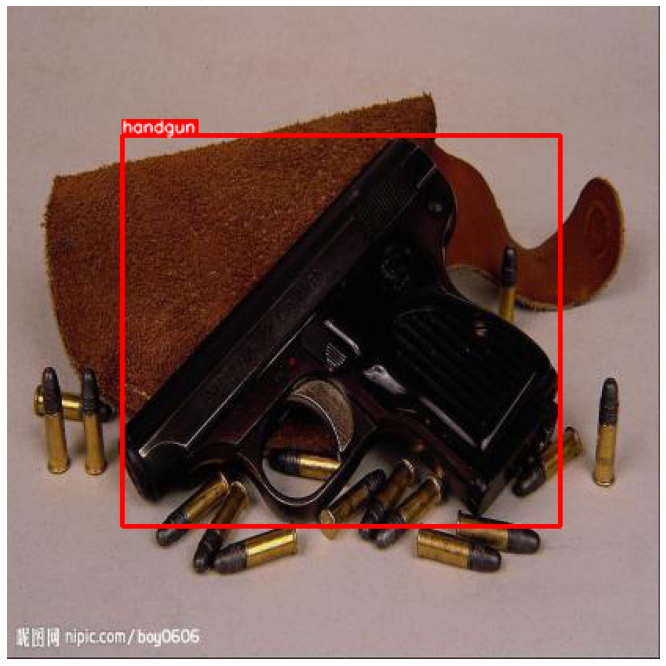

In [17]:
visualize(image, bboxes=convert_box(bboxes_nocat), category_ids = [0], category_id_to_name = {0:'handgun'})

<h2>Distribution of bounding box number in images in training set</h2>

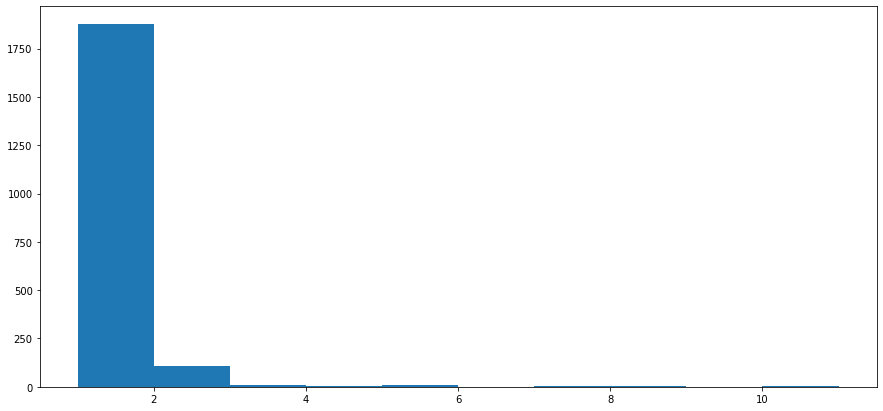

In [20]:
num_bboxes = []
for i in dictionary.values():
    num_bboxes.append(len(i))

fig = plt.figure(figsize=(15,7))
ax = plt.gca()
ax.hist(num_bboxes)
plt.show()

<h3>Example of augmented images</h3>

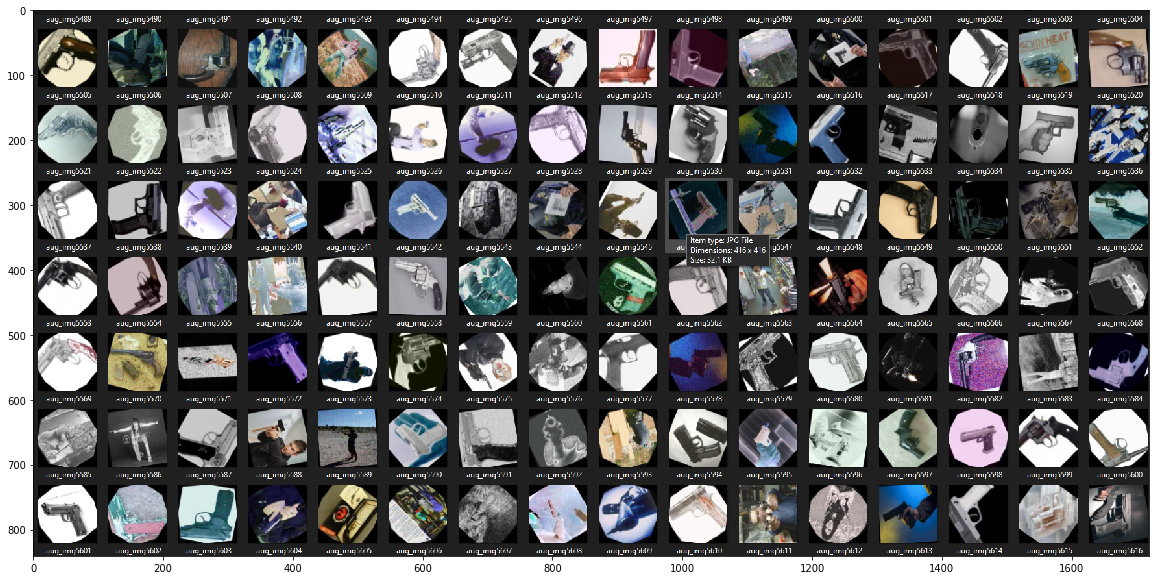

In [3]:
pillow_image1 = Image.open(f"./images/aug_imgs.jpg")
image1 = np.array(pillow_image1)
plt.figure(figsize=(20, 25))
plt.imshow(image1, interpolation='nearest')
plt.show()

In [28]:
# augment_images(picture_total=5000, source='./cleaned_data', sett='train')

pillow_image2 = Image.open(f"./cleaned_data/train/images/aug_img3306.jpg")
bbox2 = read_file('./cleaned_data/train/labels/aug_img3306.txt')
image2 = np.array(pillow_image2)

pillow_image3 = Image.open(f"./cleaned_data/train/images/aug_img4046.jpg")
bbox3 = read_file('./cleaned_data/train/labels/aug_img4046.txt')
image3 = np.array(pillow_image3)

pillow_image4 = Image.open(f"./cleaned_data/train/images/aug_img5006.jpg")
bbox4 = read_file('./cleaned_data/train/labels/aug_img5006.txt')
image4 = np.array(pillow_image4)

In [29]:
bbox3

[[0.49025218062990067,
  0.4856573828597739,
  0.8873809777226891,
  0.6995881690396258]]

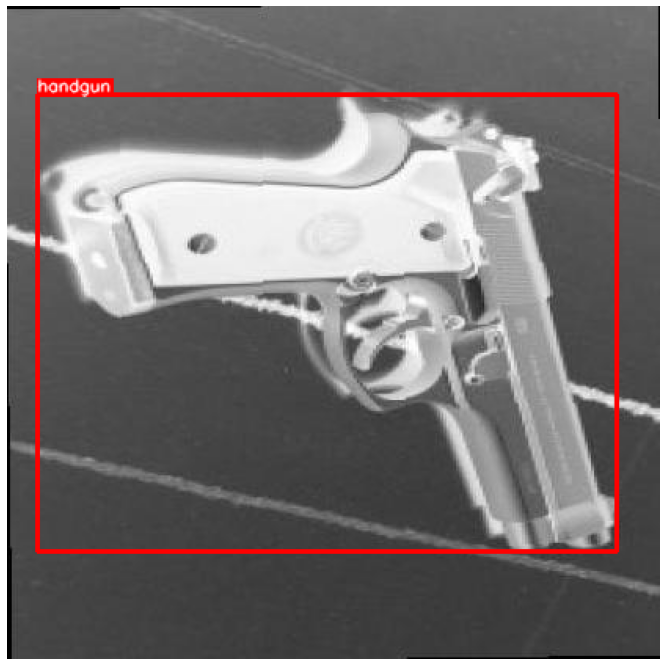

In [30]:
visualize(image3, bboxes=convert_box(bbox3), category_ids = [0], category_id_to_name = {0:'handgun'})

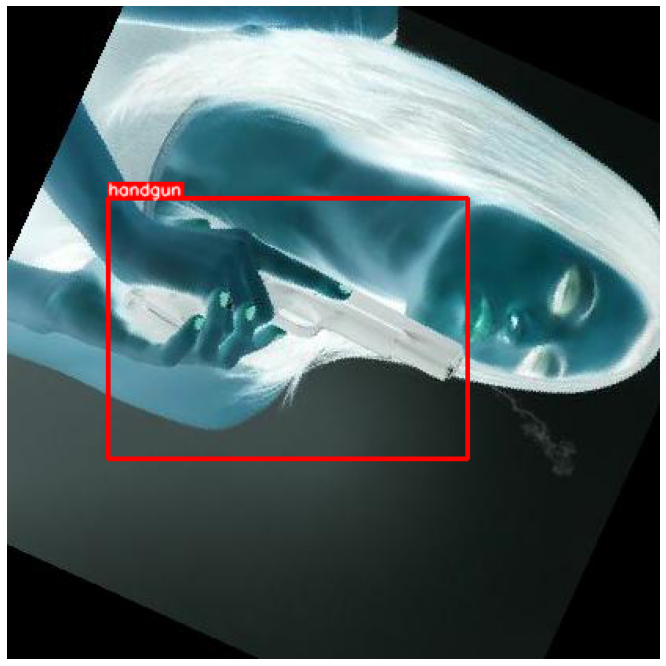

In [31]:
visualize(image2, bboxes=convert_box(bbox2), category_ids = [0], category_id_to_name = {0:'handgun'})

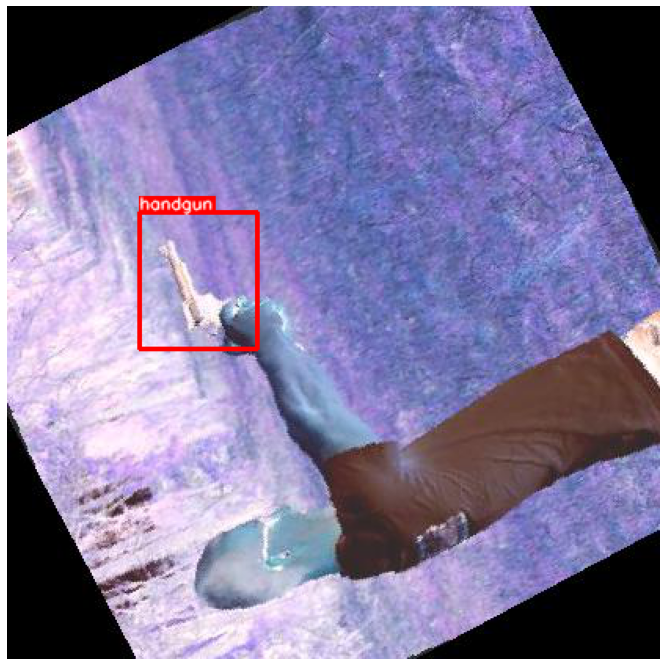

In [32]:
visualize(image4, bboxes=convert_box(bbox4), category_ids = [0], category_id_to_name = {0:'handgun'})